# UQ of temperature fields

In this notebook we show how one can use multiple batches of averages fields to perform a UQ analysis.

For this case we assume that you have a set of files already. The visualizations here rely on you having an structured mesh

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

# Hide the log for the notebook. Not recommended when running in clusters as it is better you see what happens
import os
os.environ["PYNEKTOOLS_HIDE_LOG"] = 'true'


### Define inputs

In [2]:
query_points_fname = "./points.hdf5" # In our case this file contains the mesh and the mass matrix
file_sequence = [f"mean_fields_usr{str(i+1).zfill(5)}.hdf5" for i in range(0, 10)]

## Obtain the mean and variance

For this case we can simply use the Non overlapped batch mean method, assuming that we have a number of batch means.

In [3]:
from pysemtools.io.wrappers import read_data
from pysemtools.postprocessing.statistics.uq import NOBM

# Read the mesh dat for latter plotting
mesh_data = read_data(comm, query_points_fname, ["x", "y", "z"], dtype = np.single)

# Compute the mean and variance of the specified fields
mean, var = NOBM(comm, file_sequence, ["p", "u"]) # Out puts for our particular simulation are scrambled. we had put the temperature in p and the square of the temperature in u

### Plot it

#### The mean

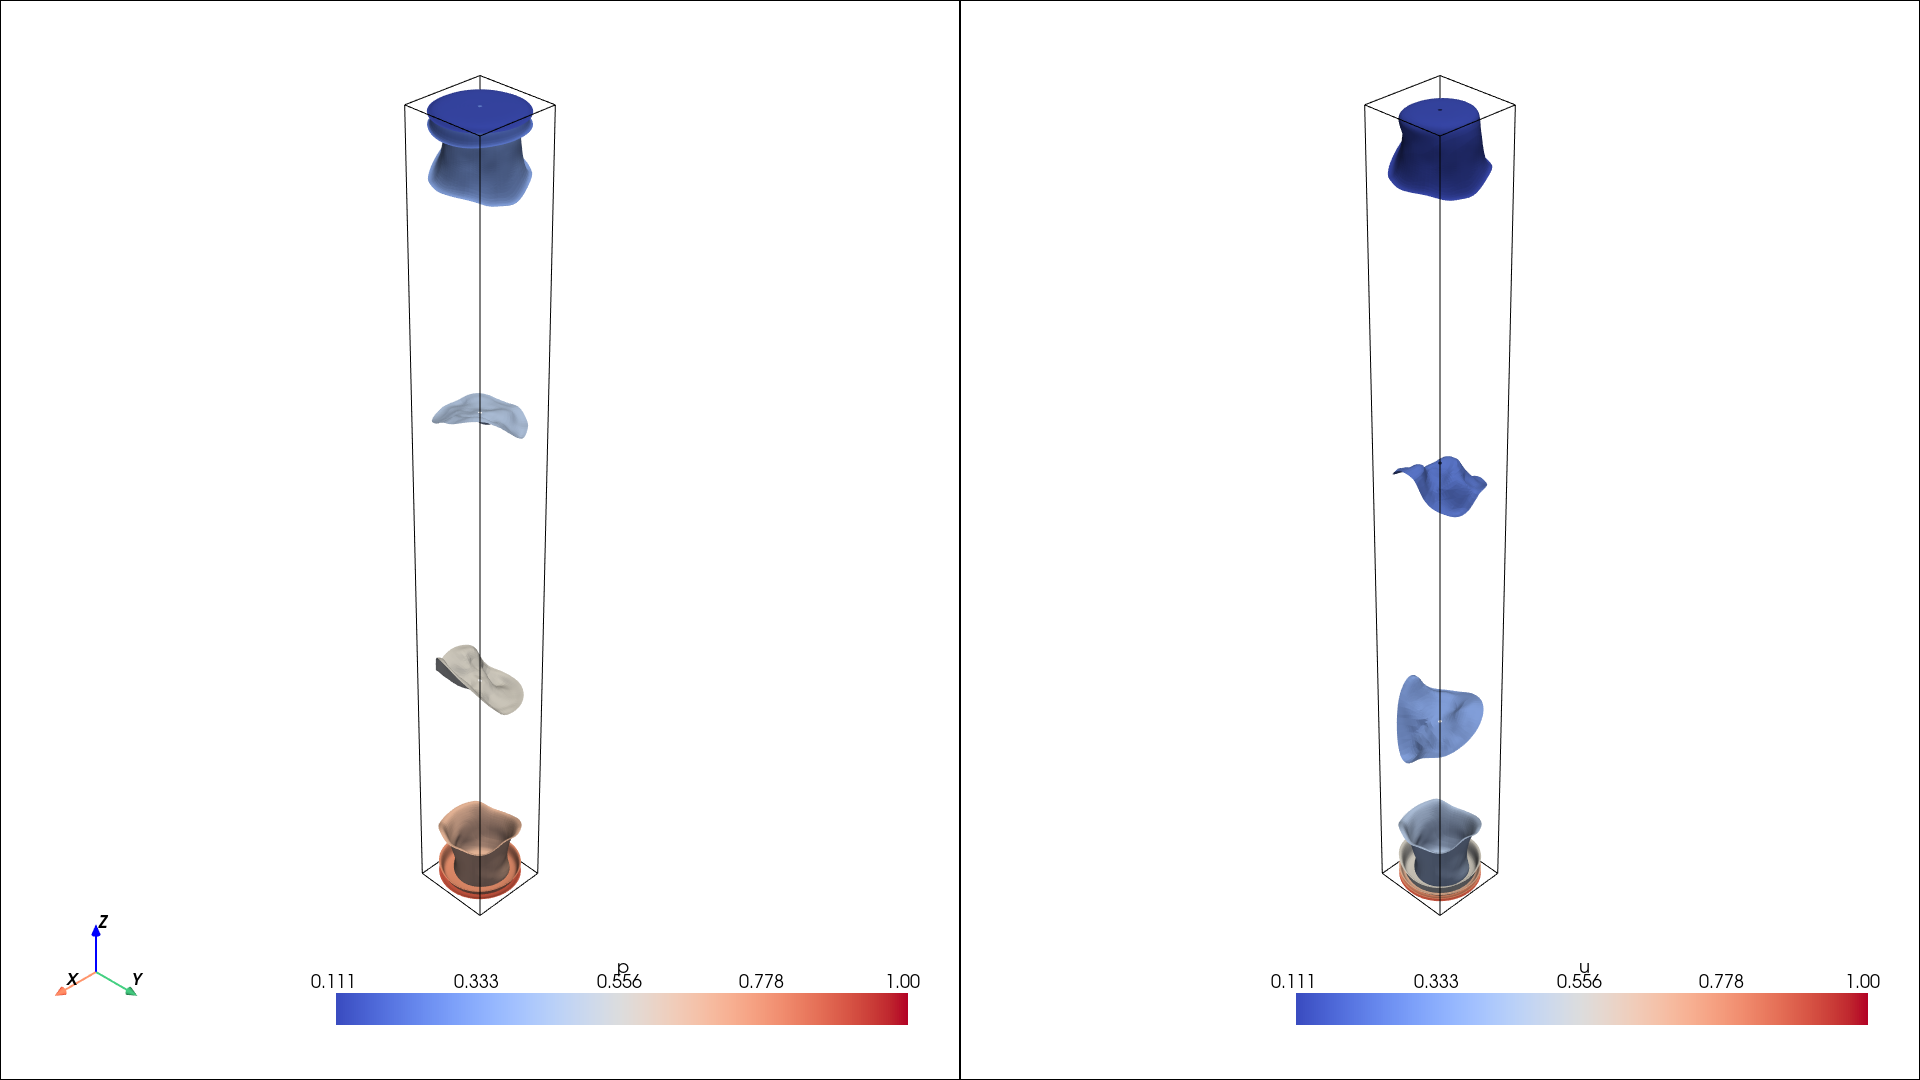

In [9]:
from pysemtools.postprocessing.plotting import isosurfaces
from IPython.display import Image, display

isos = {}
isos["p"] = np.linspace(np.min(mean["p"]), np.max(mean["p"]), 10)
isos["u"] = np.linspace(np.min(mean["u"]), np.max(mean["u"]), 10)
pl = isosurfaces(mesh_data, mean, isosurfaces = isos, shape = (1, 2), window_size = [1920, 1080], colormap="coolwarm")

for plotter in pl:
    # Capture the plot as an image and show it
    image_path = f"static_plot_SME.png"
    plotter.screenshot(image_path)
    plotter.close()
    display(Image(filename=image_path))

#### the variance

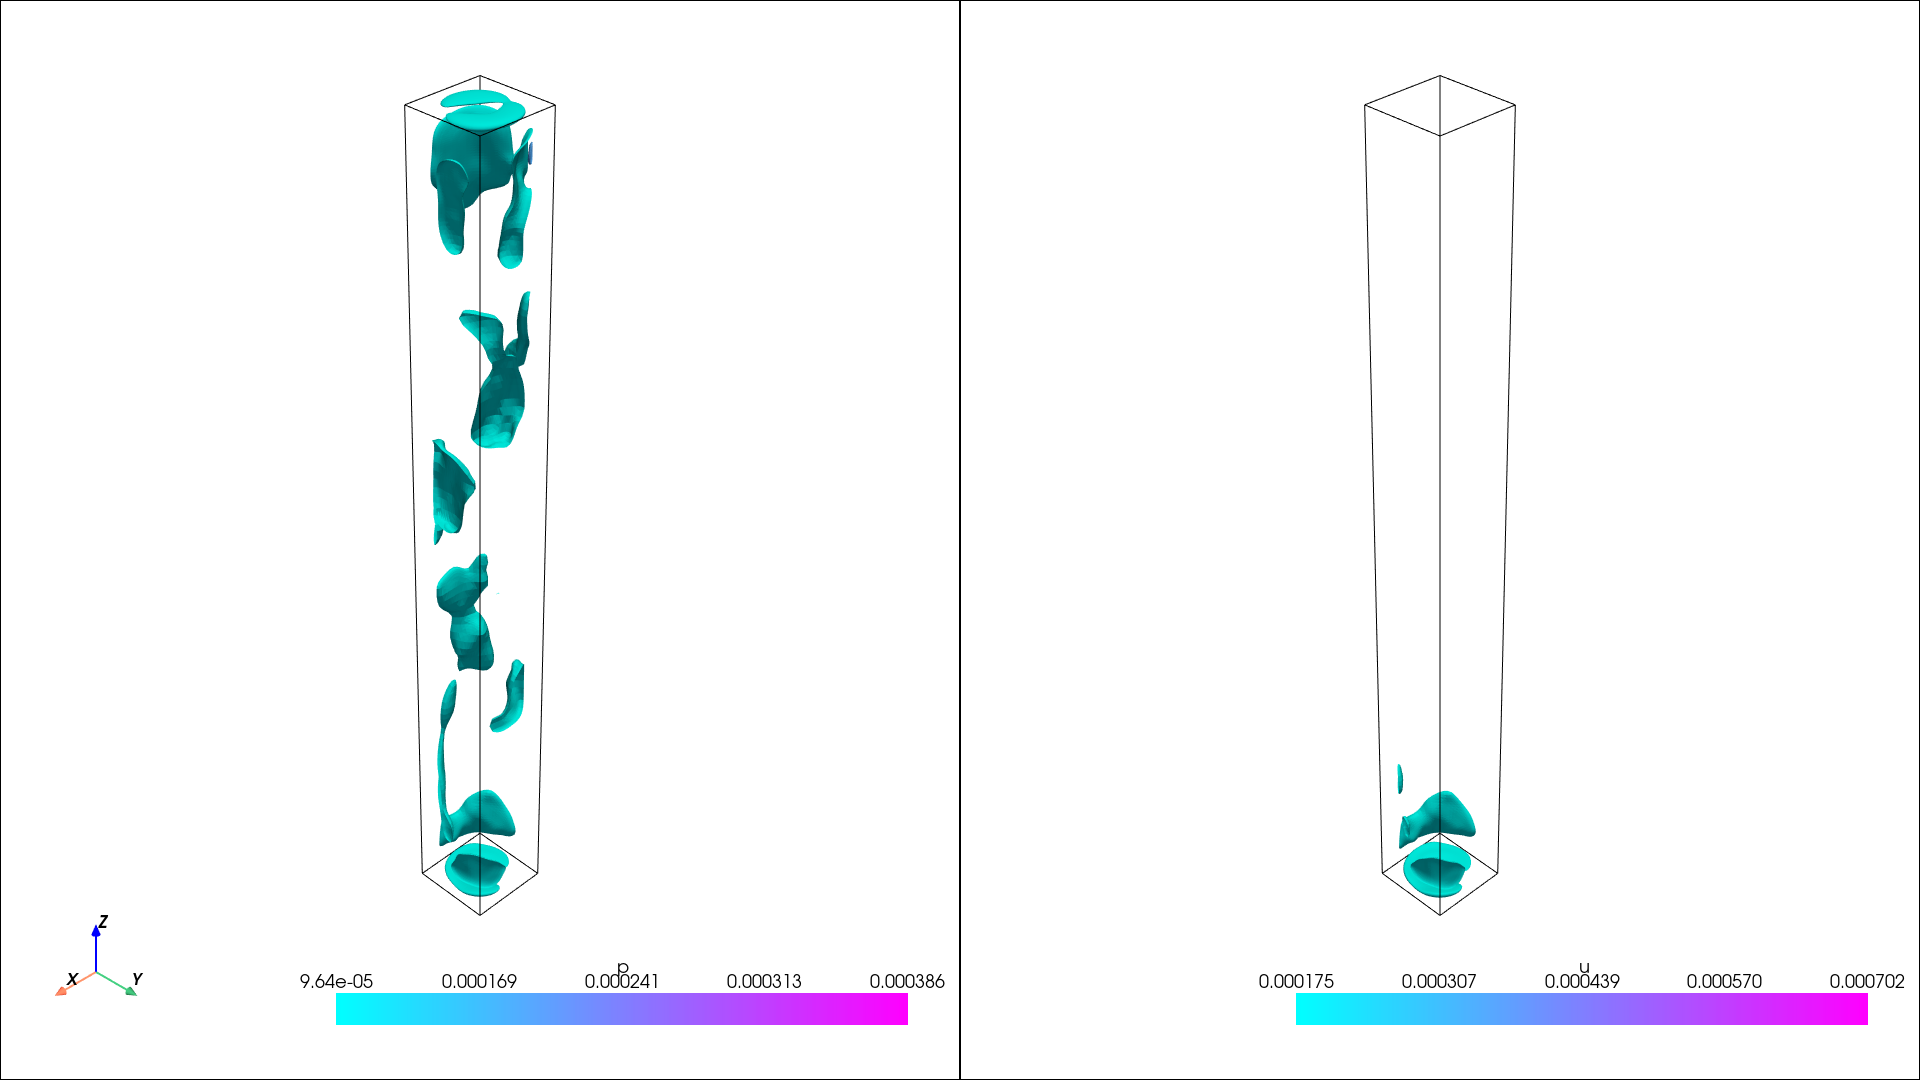

In [5]:
from pysemtools.postprocessing.plotting import isosurfaces
from IPython.display import Image, display

isos = {}
isos["p"] = np.linspace(np.min(var["p"]), np.max(var["p"]), 5)
isos["u"] = np.linspace(np.min(var["u"]), np.max(var["u"]), 5)
pl = isosurfaces(mesh_data, var, isosurfaces = isos, shape = (1, 2), window_size = [1920, 1080], colormap="cool")

for plotter in pl:
    # Capture the plot as an image and show it
    image_path = f"static_plot_SME.png"
    plotter.screenshot(image_path)
    plotter.close()
    display(Image(filename=image_path))

## Perform 2d plots

In this case, we can average in the azimuthal direction.

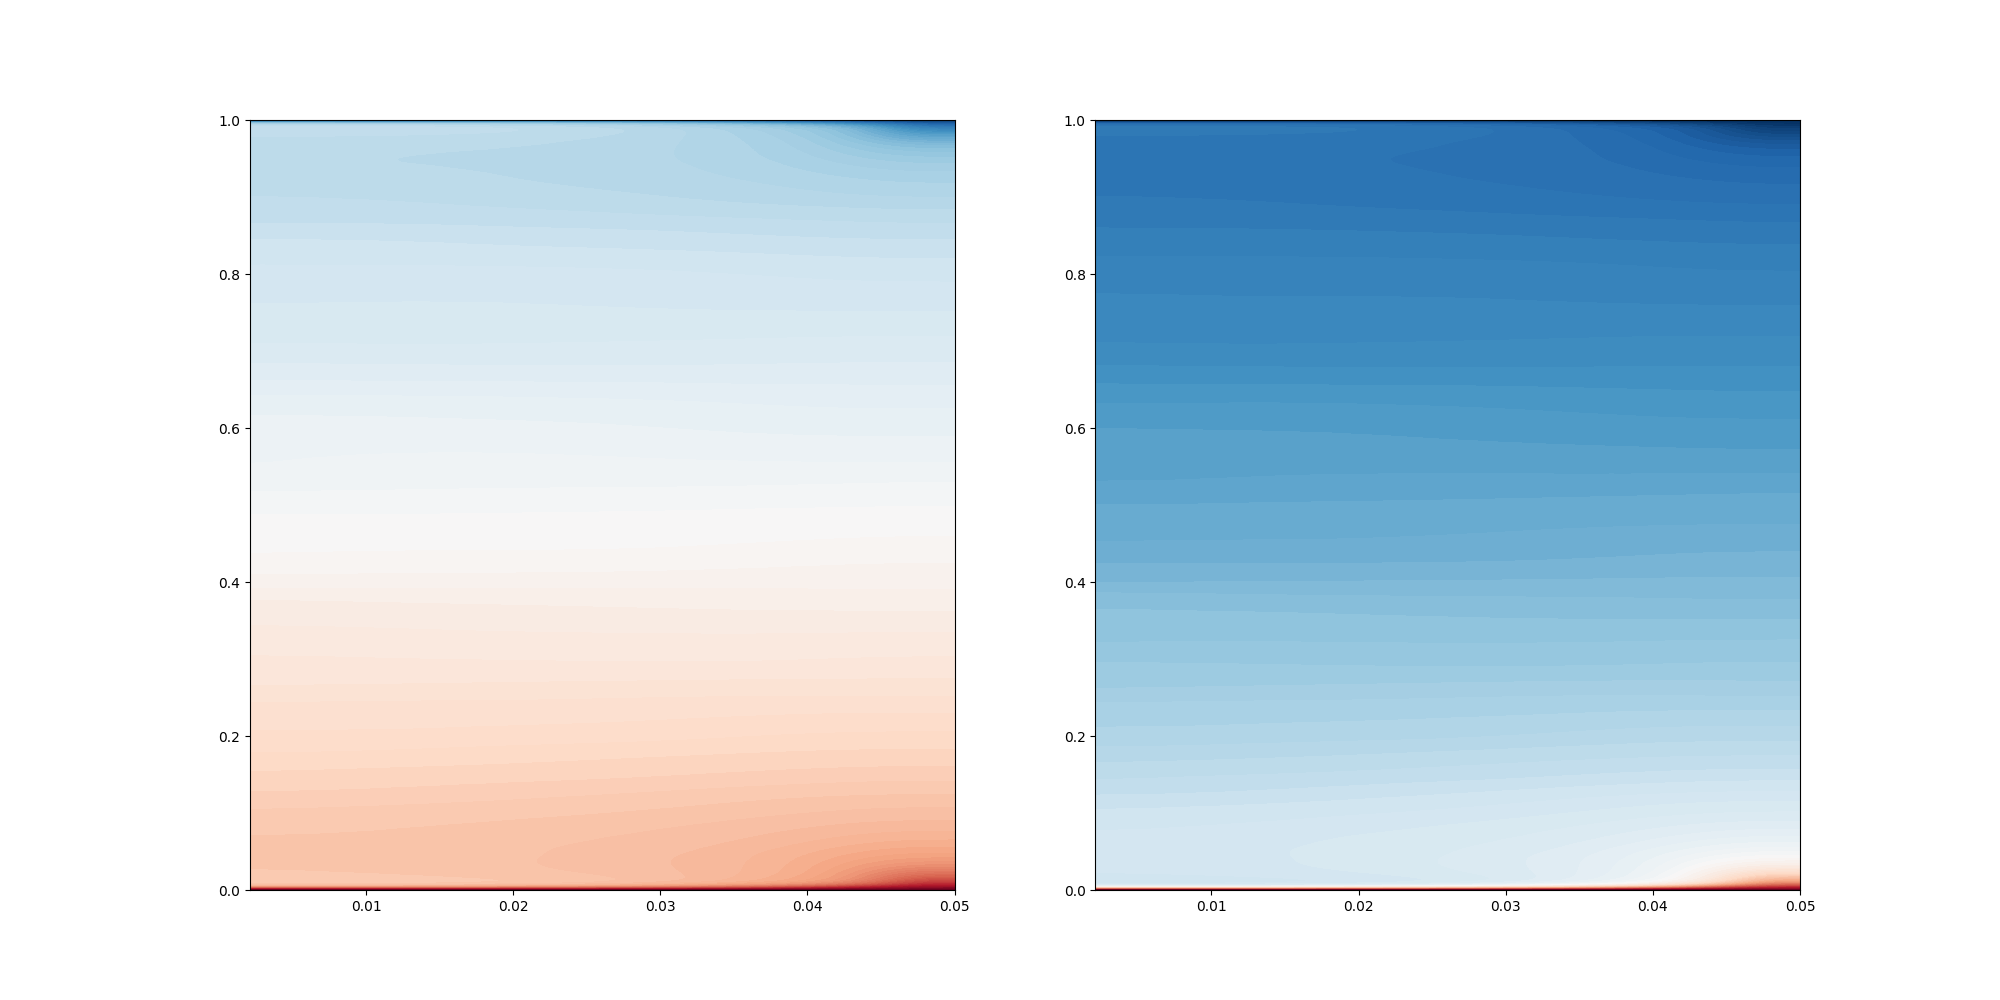

In [6]:
import h5py

# Load mass matrix
with h5py.File(query_points_fname, 'r') as f:
    bm = f["mass"][:]
bm[np.where(bm == 0)] = 1e-12

# Load the mesh
with h5py.File(query_points_fname, 'r') as f:
    r = f["r"][:]
    th = f["th"][:]
    z = f["z"][:]

t = mean["p"]
t2 = mean["u"]

#Average in the azimuthal direction direction
t_rz = np.sum(t*bm, axis=1)/ np.sum(bm, axis=1)
t2_rz = np.sum(t2*bm, axis=1)/ np.sum(bm, axis=1)

levels = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].tricontourf(r[:,0,:].flatten(),z[:,0,:].flatten(), t_rz.flatten(), levels=levels, cmap="RdBu_r")
ax[1].tricontourf(r[:,0,:].flatten(),z[:,0,:].flatten(), t2_rz.flatten(), levels=levels, cmap="RdBu_r")
#plt.show()
fig.savefig("contours.png")
plt.close()
display(Image(filename="contours.png"))


## Perform 1D plots

Plot the rotated values in 1d, by averaging in azimuthal and radial directions. In this case, this might not be so telling, as the flow is not homogenous in the radial direction, but it have give an indication on how the flow behaves.

In this case, we might have had too few points close to the wall, as we do not observe any peak in the z velocity component. Note that it would appear better if we take the square root.

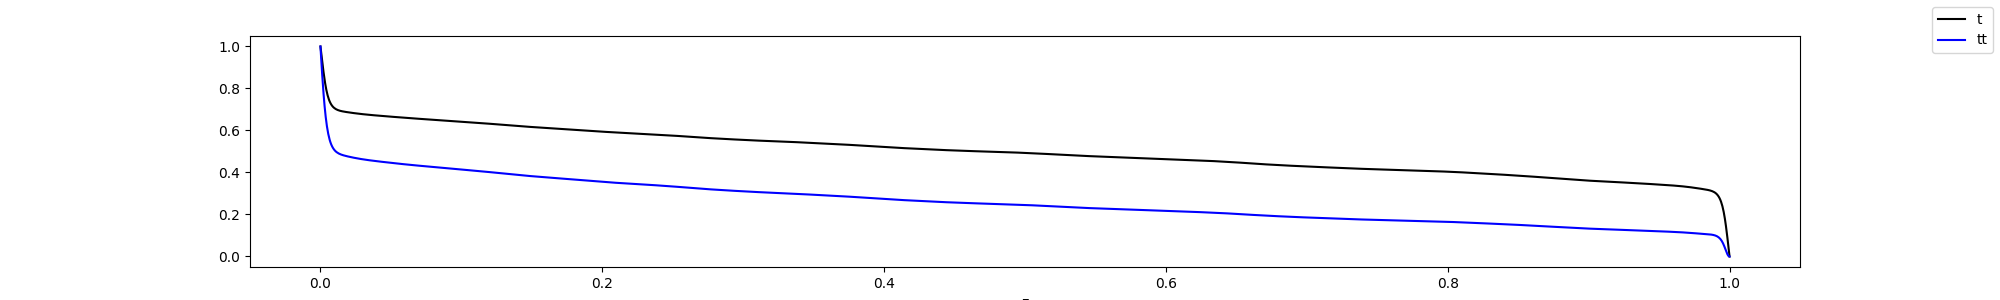

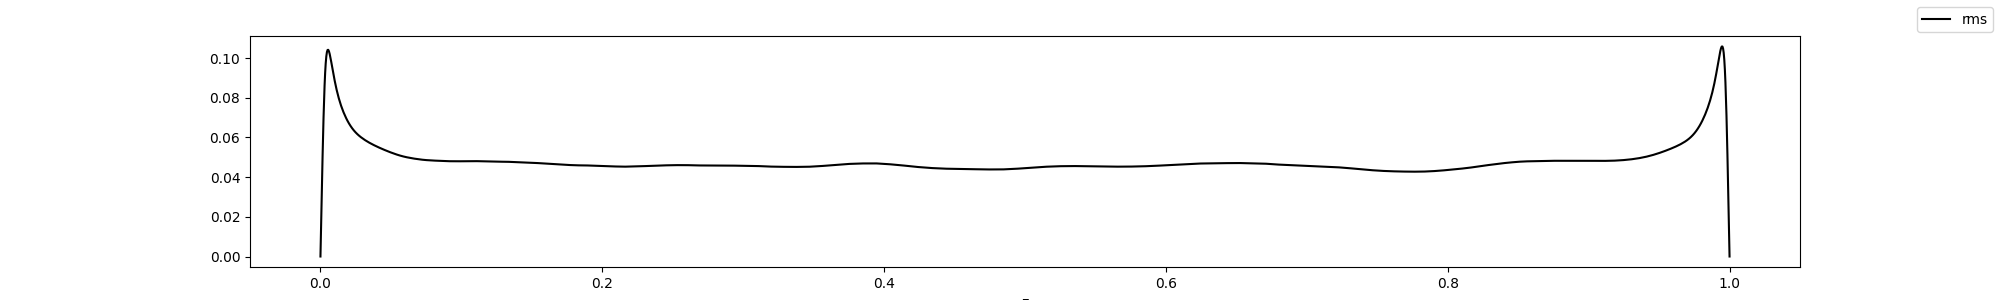

In [7]:
# Load mass matrix
with h5py.File(query_points_fname, 'r') as f:
    bm = f["mass"][:]
bm[np.where(bm == 0)] = 1e-12

t = mean["p"]
t2 = mean["u"]

# Average in the azimuthal direction and radial direction
t_z = np.sum(t*bm, axis=(0,1))/ np.sum(bm, axis=(0,1))
t2_z = np.sum(t2*bm, axis=(0,1))/ np.sum(bm, axis=(0,1))

# Get the RMS quantity # Fix small negative values related to floating point arithmetic
t_rms2 = t2_z - t_z**2
t_rms2[t_rms2 < 0] = 0
t_rms = np.sqrt(t_rms2)


fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(z[0,0,:], t_z, '-k', label="t")
ax.plot(z[0,0,:], t2_z, '-b', label="tt")
ax.set_xlabel("z")
fig.legend()
#plt.show()
fig.savefig("mean_fields.png")
plt.close()
display(Image(filename="mean_fields.png"))

fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(z[0,0,:], t_rms, '-k', label="rms")
ax.set_xlabel("z")
fig.legend()
#plt.show()
fig.savefig("rms_fields.png")
plt.close()
display(Image(filename="rms_fields.png"))